In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Define the ticker symbol
ticker = 'TSLA'

# Download adjusted close price data
data = pd.DataFrame()
data[ticker] = yf.download(ticker, start='2020-01-01', end='2024-02-24')['Adj Close']

/Users/georgespyros/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Calculate log returns from the adjusted closing prices
log_returns = np.log(1 + data.pct_change())

# Calculate drift and volatility (standard deviation) of log returns
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5 * var)
stdev = log_returns.std()

In [4]:
# Extract values from drift and stdev
drift_values = drift.values
stdev_values = stdev.values

In [5]:
# Define the number of time intervals and iterations for the simulation
t_intervals = 250
iterations = 9000

# Generate daily returns using a normal distribution
daily_returns = np.exp(drift_values + stdev_values * norm.ppf(np.random.rand(t_intervals, iterations)))

# Set the initial stock price (S0) to the last adjusted closing price in the data
S0 = data.iloc[-1]

# Create a matrix to store simulated price paths
price_list = np.zeros_like(daily_returns)
price_list[0] = S0

# Populate the price_list matrix with simulated prices
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

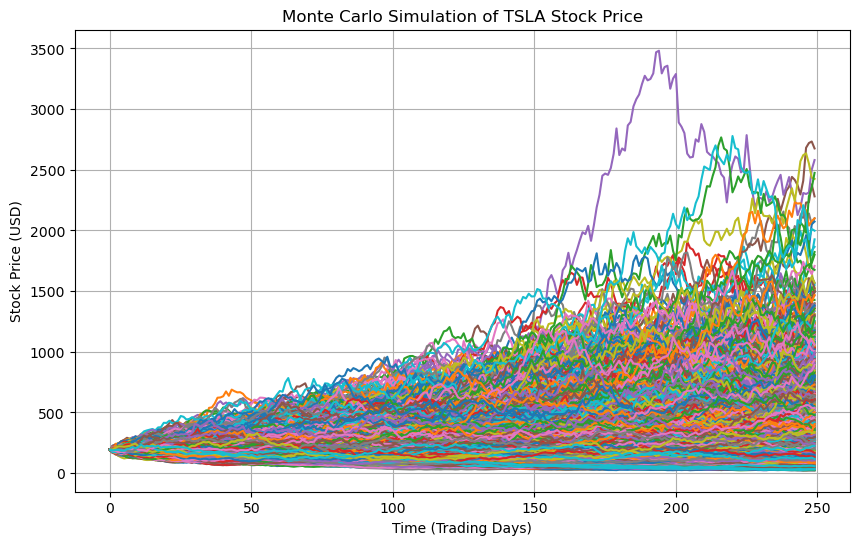

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(price_list)
plt.title(f"Monte Carlo Simulation of {ticker} Stock Price")
plt.xlabel("Time (Trading Days)")
plt.ylabel("Stock Price (USD)")
plt.grid(True)
plt.show()

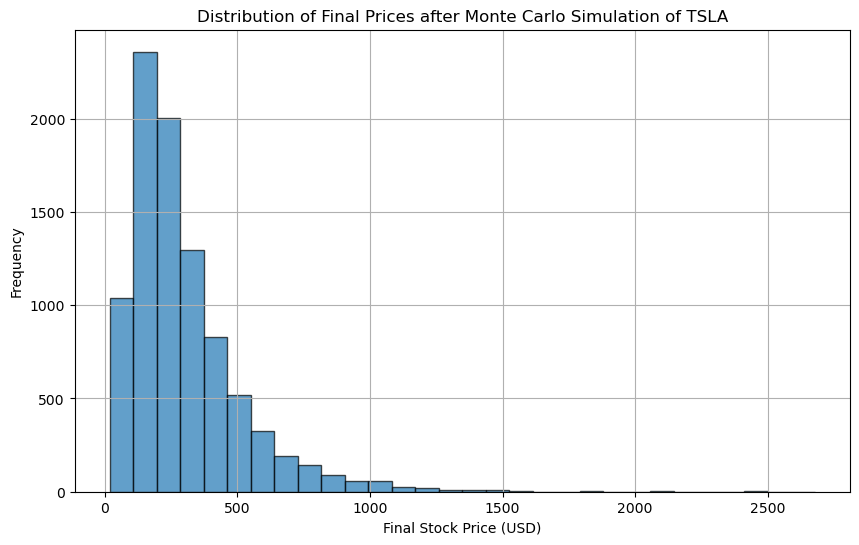

In [7]:
# Plot histogram of final prices
plt.figure(figsize=(10, 6))
plt.hist(price_list[-1], bins=30, edgecolor='black', alpha=0.7)
plt.title(f"Distribution of Final Prices after Monte Carlo Simulation of {ticker}")
plt.xlabel("Final Stock Price (USD)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [8]:
# Calculate the ending price points from the Monte Carlo simulation
ending_price_points = price_list[-1]

# Calculate expected ending price point (sample mean)
expected_ending_price_point = round(np.mean(ending_price_points), 2)
print("Expected Ending Price Point:", expected_ending_price_point)

Expected Ending Price Point: 300.26


In [9]:
# Calculate population mean (based on CAGR)
population_mean = (S0 * np.exp(u * t_intervals)).values[0]
print("Population Mean (Theoretical Expected Price):", round(population_mean, 2))

# Calculate percent difference between sample mean and population mean
percent_difference = ((expected_ending_price_point - population_mean) / population_mean) * 100
print("Percent Difference:", round(percent_difference, 2), "%")

Population Mean (Theoretical Expected Price): 302.91
Percent Difference: -0.87 %


In [10]:
# Calculate top 10% and bottom 10% of ending price points
top_ten = np.percentile(ending_price_points, 100 - 10)
bottom_ten = np.percentile(ending_price_points, 10)
print("Top 10%:", round(top_ten, 2))
print("Bottom 10%:", round(bottom_ten, 2))

Top 10%: 564.54
Bottom 10%: 102.24


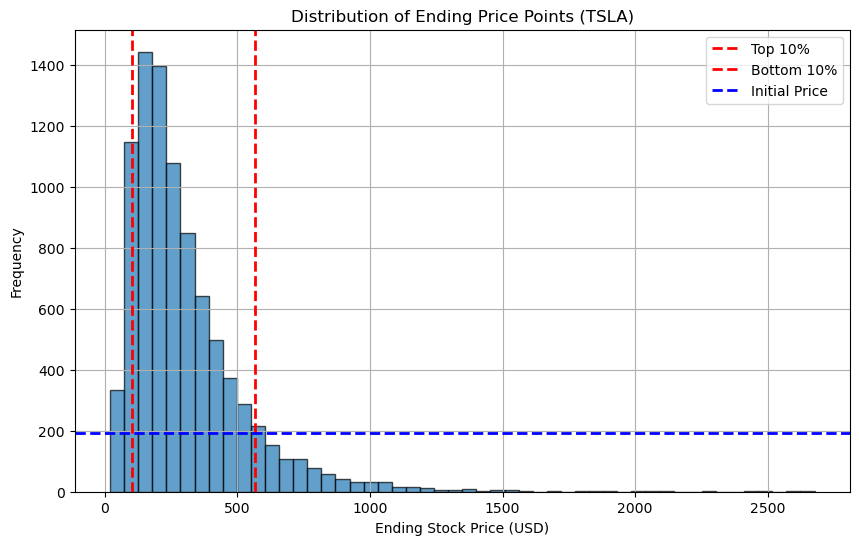

In [11]:
# Plot histogram of ending price points
plt.figure(figsize=(10, 6))
plt.hist(ending_price_points, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(top_ten, color='r', linestyle='dashed', linewidth=2, label='Top 10%')
plt.axvline(bottom_ten, color='r', linestyle='dashed', linewidth=2, label='Bottom 10%')
plt.axhline(S0.values[0], color='b', linestyle='dashed', linewidth=2, label='Initial Price')
plt.title(f"Distribution of Ending Price Points ({ticker})")
plt.xlabel("Ending Stock Price (USD)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()